In [4]:
# ============================================================================
# CELL 1: Import Required Libraries
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# CELL 2: Load Data
# ============================================================================

# Define paths
DATA_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\processed_data2"
RESULTS_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\results_advanced_v2"

# Create results directory if it doesn't exist
os.makedirs(RESULTS_PATH, exist_ok=True)

print("Loading data from:", DATA_PATH)

# Load Mel Spectrograms (Audio)
# Shape: (1766, 128, 128)
audio_data = np.load(os.path.join(DATA_PATH, 'mel_spectrograms_normalized.npy'))
# Add channel dimension for CNN: (N, 1, 128, 128)
audio_data = audio_data[:, np.newaxis, :, :]

# Load Lyrics Embeddings (Text)
# Shape: (1766, 100)
text_data = np.load(os.path.join(DATA_PATH, 'lyrics_embeddings.npy'))

# Load Labels (if available, for ARI)
labels_path = os.path.join(DATA_PATH, 'labels.npy')
if os.path.exists(labels_path):
    labels = np.load(labels_path, allow_pickle=True)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    print(f"Labels loaded: {len(np.unique(labels))} classes")
else:
    labels_encoded = None
    print("Labels not found. ARI calculation will be skipped.")

print(f"Audio data shape: {audio_data.shape}")
print(f"Text data shape: {text_data.shape}")

# Convert to PyTorch tensors
audio_tensor = torch.FloatTensor(audio_data)
text_tensor = torch.FloatTensor(text_data)

# Create Dataset
full_dataset = TensorDataset(audio_tensor, text_tensor)

# Split into Train/Validation (85% Train, 15% Validation)
train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Using device: cuda
Loading data from: f:\BRACU\Semester 12 Final\CSE425\FInal_project\processed_data2
Labels loaded: 7 classes
Audio data shape: (1336, 1, 256, 1024)
Text data shape: (1336, 100)
Training samples: 1135
Validation samples: 201


In [7]:

class HybridVAE(nn.Module):
    def __init__(self, latent_dim=128, text_dim=100):
        super(HybridVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # --- Audio Encoder (CNN) ---
        # Input: (1, 256, 1024)
        self.audio_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),   # -> (32, 128, 512)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (64, 64, 256)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # -> (128, 32, 128)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# -> (256, 16, 64)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),# -> (512, 8, 32)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),# -> (512, 4, 16)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Flatten() # -> 512 * 4 * 16 = 32768
        )
        # Audio feature projection
        self.audio_fc = nn.Linear(32768, 1024)
        
        # --- Text Encoder (Dense) ---
        # Input: (100)
        self.text_encoder = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU()
        )
        
        # --- Fusion & Latent Space ---
        # Concatenate Audio (1024) + Text (128) = 1152
        self.fc_fusion = nn.Linear(1024 + 128, 512)
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # --- Decoder Split ---
        self.decoder_input = nn.Linear(latent_dim, 512)
        self.decoder_split = nn.Linear(512, 1024 + 128) # Split back to audio/text hidden dims
        
        # --- Audio Decoder (Transposed CNN) ---
        self.audio_decoder_fc = nn.Linear(1024, 32768)
        
        self.audio_decoder = nn.Sequential(
            nn.Unflatten(1, (512, 4, 16)),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (512, 8, 32)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (256, 16, 64)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (128, 32, 128)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (64, 64, 256)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (32, 128, 512)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (1, 256, 1024)
        )

        # --- Text Decoder ---
        self.text_decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, text_dim)
        )
        
    def encode(self, audio, text):
        a = self.audio_encoder(audio)
        a = self.audio_fc(a)
        
        t = self.text_encoder(text)
        
        combined = torch.cat((a, t), dim=1)
        h = torch.relu(self.fc_fusion(combined))
        
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.decoder_input(z))
        splits = torch.relu(self.decoder_split(h))
        
        # Split back into audio (1024) and text (128)
        a_hidden = splits[:, :1024]
        t_hidden = splits[:, 1024:]
        
        # Decode audio
        a_unfl = torch.relu(self.audio_decoder_fc(a_hidden))
        recon_audio = self.audio_decoder(a_unfl)
        
        # Decode text
        recon_text = self.text_decoder(t_hidden)
        
        return recon_audio, recon_text
    
    def forward(self, audio, text):
        mu, logvar = self.encode(audio, text)
        z = self.reparameterize(mu, logvar)
        recon_audio, recon_text = self.decode(z)
        return recon_audio, recon_text, mu, logvar

# Loss function
def loss_function(recon_audio, audio, recon_text, text, mu, logvar, alpha=1.0, beta=1.0):
    # Audio Reconstruction Loss (MSE)
    # Flatten for MSE
    recon_loss_audio = nn.functional.mse_loss(recon_audio, audio, reduction='sum')
    
    # Text Reconstruction Loss (MSE)
    recon_loss_text = nn.functional.mse_loss(recon_text, text, reduction='sum')
    
    # KL Divergence
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss with weighting
    # Alpha balances audio vs text importance. Text is much smaller dimension, likely needs boosting or good MSE balance.
    # New Dimensions: Audio (262k), Text (100). Imbalance is huge (~2600x).
    # Increased text weighting to 150 to keep it relevant.
    
    return recon_loss_audio + recon_loss_text * 2500 + kld * beta, recon_loss_audio, recon_loss_text, kld

print("Hybrid VAE model defined.")

Hybrid VAE model defined.


Starting training...
Epoch 1/500 | Train Loss: 418704.5035 | Val Loss: 298927.9726 (Audio: 385724.01, Text: 11.05)
Epoch 2/500 | Train Loss: 280196.2877 | Val Loss: 235875.6014 (Audio: 268298.54, Text: 4.63)
Epoch 3/500 | Train Loss: 238144.3315 | Val Loss: 217608.6399 (Audio: 234188.56, Text: 1.38)
Epoch 4/500 | Train Loss: 221523.6308 | Val Loss: 208481.2220 (Audio: 218295.83, Text: 1.07)
Epoch 5/500 | Train Loss: 213893.1604 | Val Loss: 203861.0367 (Audio: 210926.19, Text: 0.98)
Epoch 6/500 | Train Loss: 206433.9958 | Val Loss: 195634.4366 (Audio: 203507.84, Text: 0.99)
Epoch 7/500 | Train Loss: 198571.2211 | Val Loss: 192651.7164 (Audio: 195676.93, Text: 0.99)
Epoch 8/500 | Train Loss: 192500.3630 | Val Loss: 182765.4142 (Audio: 189598.55, Text: 1.00)
Epoch 9/500 | Train Loss: 187560.2372 | Val Loss: 177489.8856 (Audio: 184688.31, Text: 0.96)
Epoch 10/500 | Train Loss: 183095.1716 | Val Loss: 173495.7400 (Audio: 180239.01, Text: 0.95)
Epoch 11/500 | Train Loss: 178287.6967 | Val Lo

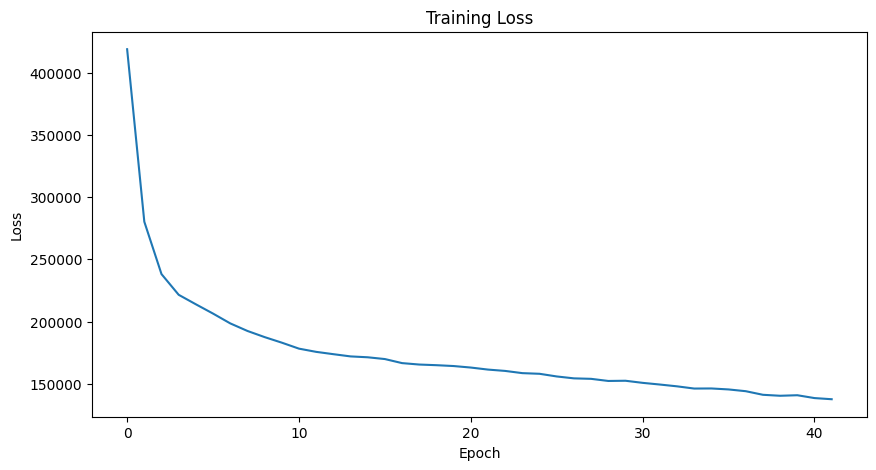

In [8]:
# Hyperparameters
LATENT_DIM = 128
EPOCHS = 500 # Increased epochs since we have early stopping
LEARNING_RATE = 1e-4
PATIENCE = 15

# Initialize model
model = HybridVAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting training...")
train_losses = []
best_loss = float('inf')
patience_counter = 0

model.train()

for epoch in range(EPOCHS):
    total_epoch_loss = 0
    total_audio_loss = 0
    total_text_loss = 0
    total_kld = 0
    
    model.train()
    for batch_idx, (audio, text) in enumerate(train_loader):
        audio = audio.to(device)
        text = text.to(device)
        
        optimizer.zero_grad()
        
        recon_audio, recon_text, mu, logvar = model(audio, text)
        
        loss, l_audio, l_text, l_kld = loss_function(recon_audio, audio, recon_text, text, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        total_epoch_loss += loss.item()
        total_audio_loss += l_audio.item()
        total_text_loss += l_text.item()
        total_kld += l_kld.item()
        
    avg_train_loss = total_epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # --- Validation Loop ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for audio, text in val_loader:
            audio = audio.to(device)
            text = text.to(device)
            
            recon_audio, recon_text, mu, logvar = model(audio, text)
            val_loss, _, _, _ = loss_function(recon_audio, audio, recon_text, text, mu, logvar)
            total_val_loss += val_loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} '
          f'(Audio: {total_audio_loss/len(train_loader.dataset):.2f}, '
          f'Text: {total_text_loss/len(train_loader.dataset):.2f})')
          
    # Early Stopping Check (Monitor Validation Loss)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        # Optional: Save best model state
        # torch.save(model.state_dict(), os.path.join(RESULTS_PATH, 'best_model.pth'))
    else:
        patience_counter += 1
        print(f"  Patience {patience_counter}/{PATIENCE} (Val Loss did not improve)")
        
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(os.path.join(RESULTS_PATH, 'training_loss.png'))
plt.show()

In [9]:
print("Extracting latent features...")
model.eval()
latent_vectors = []

with torch.no_grad():
    # Process entire dataset in batches to avoid OOM even during inference if large
    # Using existing dataloader but we strictly want order preserved if we interpret against labels?
    # Actually dataloader is shuffled. We should create a non-shuffled loader for extraction matching indices.
    
    eval_dataset = TensorDataset(audio_tensor, text_tensor)
    eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    for audio, text in eval_loader:
        audio = audio.to(device)
        text = text.to(device)
        mu, _ = model.encode(audio, text)
        latent_vectors.append(mu.cpu().numpy())

latent_matrix = np.vstack(latent_vectors)
print(f"Latent matrix shape: {latent_matrix.shape}")

# Save latent features
np.save(os.path.join(RESULTS_PATH, 'hybrid_latent_features.npy'), latent_matrix)

Extracting latent features...
Latent matrix shape: (1336, 128)


In [12]:
print("\n--- Finding Optimal Parameters for Each Algorithm ---")

# User requested range(2, 15)
k_range = range(2, 15) 

# --- 1. K-Means Optimization ---
print("\n[1] Optimizing K-Means (K=2..14)...")
best_k_kmeans = 2
best_sil_kmeans = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(latent_matrix)
    sil = silhouette_score(latent_matrix, labels)
    print(f"  K={k}: Silhouette={sil:.4f}")
    
    if sil > best_sil_kmeans:
        best_sil_kmeans = sil
        best_k_kmeans = k

print(f"Optimal K for K-Means: {best_k_kmeans}")


# --- 2. Agglomerative Clustering Optimization ---
print("\n[2] Optimizing Agglomerative Clustering (K=2..14)...")
best_k_agg = 2
best_sil_agg = -1

for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(latent_matrix)
    sil = silhouette_score(latent_matrix, labels)
    print(f"  K={k}: Silhouette={sil:.4f}")
    
    if sil > best_sil_agg:
        best_sil_agg = sil
        best_k_agg = k

print(f"Optimal K for Agglomerative: {best_k_agg}")


# --- 3. DBSCAN Optimization ---
print("\n[3] Optimizing DBSCAN (Eps search)...")
best_eps = 5.0 # Start with a reasonable default for high-dim
best_sil_db = -1
# In 128-dim space, distances are much larger (expected ~10-15). 
# Range 0.5-5.0 is too small. Increasing to 3.0-20.0
eps_range = np.arange(3.0, 20.0, 1.0)

for eps in eps_range:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(latent_matrix)
    
    # Check valid clusters (ignoring noise -1)
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)
    
    if len(unique_labels) >= 2:
        sil = silhouette_score(latent_matrix, labels)
        print(f"  Eps={eps:.1f}: Clusters={len(unique_labels)}, Noise={list(labels).count(-1)}, Silhouette={sil:.4f}")
        
        if sil > best_sil_db:
            best_sil_db = sil
            best_eps = eps
    else:
        print(f"  Eps={eps:.1f}: Clusters={len(unique_labels)} (Not enough / All noise)")

if best_sil_db == -1:
    print("  No optimal DBSCAN config found. Defaulting to eps=10.0")
    best_eps = 10.0
else:
    print(f"Optimal Eps for DBSCAN: {best_eps:.1f} (Silhouette={best_sil_db:.4f})")


print("\n--- Final Clustering with Optimal Parameters ---")

clustering_algos = {
    f'K-Means-Main (k={best_k_kmeans})': KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10),
    'K-Means-Language (k=2)': KMeans(n_clusters=2, random_state=42, n_init=10),
    f'Agglomerative (k={best_k_agg})': AgglomerativeClustering(n_clusters=best_k_agg),
    f'DBSCAN (eps={best_eps:.1f})': DBSCAN(eps=best_eps, min_samples=5)
}

results_data = []

for name, algo in clustering_algos.items():
    print(f"\nRunning {name}...")
    
    # Fit and Predict
    labels_pred = algo.fit_predict(latent_matrix)
    
    # Store labels in the algorithm object for visualization later
    if hasattr(algo, 'labels_'):
         algo.labels_ = labels_pred 
    
    # Metrics
    n_clusters_found = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
    print(f"Number of clusters found: {n_clusters_found}")
    
    if n_clusters_found > 1:
        sil = silhouette_score(latent_matrix, labels_pred)
        db = davies_bouldin_score(latent_matrix, labels_pred)
        # ARI requires ground truth labels
        if labels_encoded is not None:
            ari = adjusted_rand_score(labels_encoded, labels_pred)
        else:
            ari = None
            
        print(f"Silhouette Score: {sil:.4f}")
        print(f"Davies-Bouldin Index: {db:.4f}")
        if ari is not None:
            print(f"Adjusted Rand Index: {ari:.4f}")
            
        results_data.append({
            'Algorithm': name,
            'Silhouette': sil,
            'Davies-Bouldin': db,
            'ARI': ari,
            'n_clusters': n_clusters_found
        })
    else:
        print("Not enough clusters for metric calculation.")
        results_data.append({
            'Algorithm': name,
            'Silhouette': -1,
            'Davies-Bouldin': -1,
            'ARI': -1,
            'n_clusters': n_clusters_found
        })


--- Finding Optimal Parameters for Each Algorithm ---

[1] Optimizing K-Means (K=2..14)...
  K=2: Silhouette=0.1994
  K=3: Silhouette=0.1126
  K=4: Silhouette=0.1094
  K=5: Silhouette=0.0963
  K=6: Silhouette=0.0816
  K=7: Silhouette=0.0751
  K=8: Silhouette=0.0747
  K=9: Silhouette=0.0748
  K=10: Silhouette=0.0726
  K=11: Silhouette=0.0705
  K=12: Silhouette=0.0692
  K=13: Silhouette=0.0623
  K=14: Silhouette=0.0631
Optimal K for K-Means: 2

[2] Optimizing Agglomerative Clustering (K=2..14)...
  K=2: Silhouette=0.1794
  K=3: Silhouette=0.1021
  K=4: Silhouette=0.0622
  K=5: Silhouette=0.0567
  K=6: Silhouette=0.0509
  K=7: Silhouette=0.0462
  K=8: Silhouette=0.0466
  K=9: Silhouette=0.0420
  K=10: Silhouette=0.0432
  K=11: Silhouette=0.0405
  K=12: Silhouette=0.0352
  K=13: Silhouette=0.0365
  K=14: Silhouette=0.0350
Optimal K for Agglomerative: 2

[3] Optimizing DBSCAN (Eps search)...
  Eps=3.0: Clusters=0 (Not enough / All noise)
  Eps=4.0: Clusters=0 (Not enough / All noise)
  Eps


Final Results:
                Algorithm  Silhouette  Davies-Bouldin       ARI  n_clusters
0      K-Means-Main (k=2)    0.199363        1.740146  0.087201           2
1  K-Means-Language (k=2)    0.199363        1.740146  0.087201           2
2     Agglomerative (k=2)    0.179438        1.856148  0.078281           2
3        DBSCAN (eps=8.0)   -0.114480        3.668379  0.004735           2

Generating t-SNE visualization...


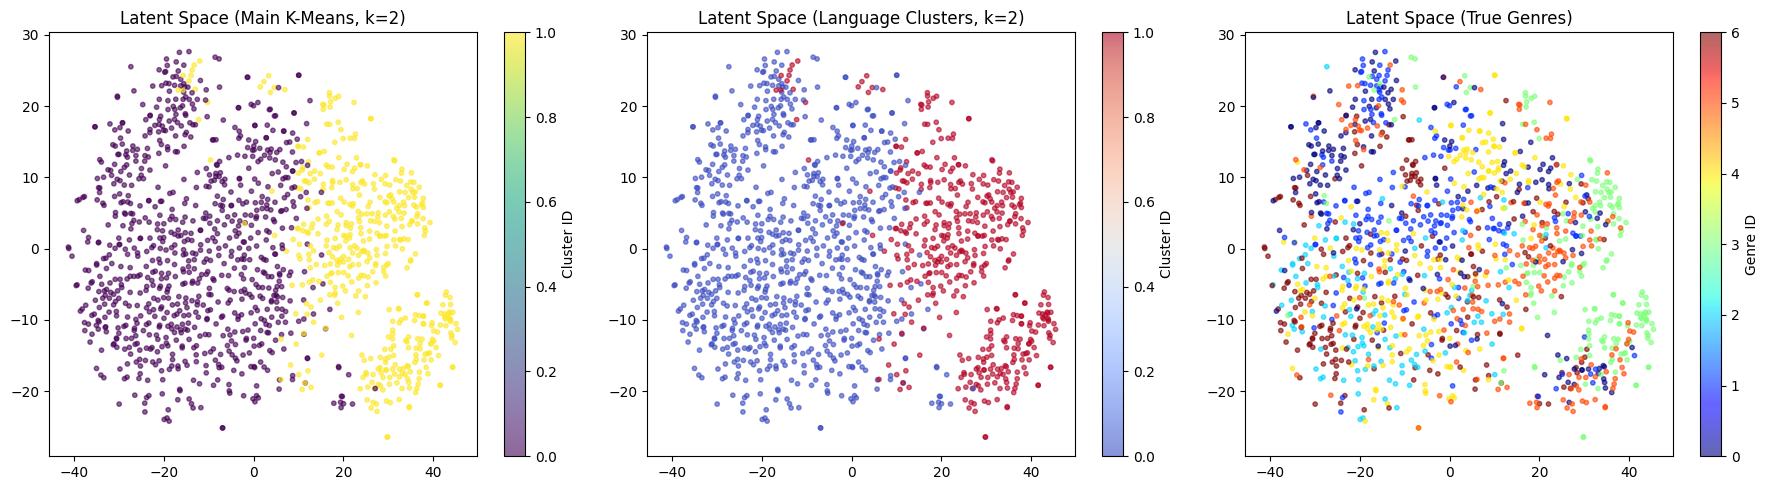

Done. Results saved in f:\BRACU\Semester 12 Final\CSE425\FInal_project\results_advanced_v2


In [13]:
# Convert results to DataFrame
df_results = pd.DataFrame(results_data)
print("\nFinal Results:")
print(df_results)

# Save results to CSV
df_results.to_csv(os.path.join(RESULTS_PATH, 'clustering_metrics.csv'), index=False)

# t-SNE Visualization
# Ensure we have labels from our runs. The keys in clustering_algos now incorporate k.
# We need to find the specific keys we created dynamically or just iterate.
# We know the specific naming convention we used.

kmeans_main_key = f'K-Means-Main (k={best_k_kmeans})'
kmeans_lang_key = 'K-Means-Language (k=2)'

kmeans_main_labels = clustering_algos[kmeans_main_key].labels_
kmeans_lang_labels = clustering_algos[kmeans_lang_key].labels_

print("\nGenerating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_matrix)

plt.figure(figsize=(18, 5))

# Plot 1: Main K-Means Clusters
plt.subplot(1, 3, 1)
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=kmeans_main_labels, cmap='viridis', alpha=0.6, s=10)
plt.title(f'Latent Space (Main K-Means, k={best_k_kmeans})')
plt.colorbar(label='Cluster ID')

# Plot 2: Language Clusters
plt.subplot(1, 3, 2)
# Using a contrasting colormap for binary/small class count
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=kmeans_lang_labels, cmap='coolwarm', alpha=0.6, s=10)
plt.title('Latent Space (Language Clusters, k=2)')
plt.colorbar(label='Cluster ID')

# Plot 3: Ground Truth Genres (if available)
plt.subplot(1, 3, 3)
if labels_encoded is not None:
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels_encoded, cmap='jet', alpha=0.6, s=10)
    plt.title('Latent Space (True Genres)')
    plt.colorbar(label='Genre ID')
else:
    plt.text(0.5, 0.5, 'No True Labels Available', ha='center')
    plt.title('Latent Space (True Genres)')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'tsne_clusters_v2.png'))
plt.show()

print("Done. Results saved in", RESULTS_PATH)
